## Data Analysis Continued

In [ ]:
#!pip install shap

In [ ]:
#!pip install xgboost

<a id=menu></a>
### Menu
* [Imports](#imports) 
* [Read Data](#data)
* [Target Variable](#target_var)
* [Data Exploration](#data_exploration)
* [Random Forest on Original Dataframe](#random_forest_before)
* [Feature Creation](#new_features)
    * [Important Functions](#important_functions)
    * [Decision Tree with New Features](#decisiontree)
    * [Linear Regression with New Features](#linear_regression)
    * [Random Forest with New Features](#random_forest)
    * [XGBoost with New Features](#xgboost)

In this notebook I will:
- create new features to increase complexity of the model and hopefully get better models
- I will run:
        -linear regression
        -Decision Tree
        -Random Forest
        -XGBoost regressor
- on each of these models I will run randomized search for best hyperparameters, then run cross_validation on the model.

<a id=imports></a>
### Imports

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from datetime import datetime
import os

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import shap
from scipy import stats
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

<a id=data></a>
### Data

In [2]:
data = pd.read_csv('../cleaned_data/data_with_all_customer_ids.csv', index_col=0, parse_dates = ['InvoiceDate'])

In [3]:
#data.head()
#data.shape
data.isna().sum()


Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    226860
Country             0
Date                0
Sales               0
Year                0
Month               0
Day                 0
Quarter             0
Week                0
Week_day            0
Day_of_year         0
dtype: int64

In [4]:
#replace nans with guest for customer id
data['Customer ID'].fillna('guest',inplace=True)
data.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
Date           0
Sales          0
Year           0
Month          0
Day            0
Quarter        0
Week           0
Week_day       0
Day_of_year    0
dtype: int64

The purpose of this kernel is to predict the daily amount of product sales, as well as the daily total sales, so the dataframe needs to be altered a bit. Product description, customer ID and country will be lost but they are not needed to predict quantity sold and total daily sales. 

In [5]:
df = data[['InvoiceDate','StockCode','Year','Month','Day','Quarter','Week','Week_day','Day_of_year','Quantity','Sales']]


In [ ]:
#df.head()

[Menu](#menu)
<a id=target_var></a>
### Target Variable

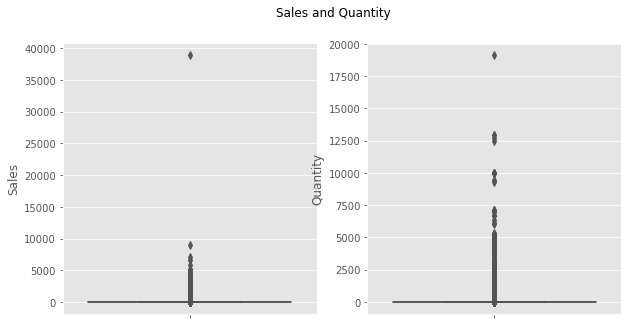

In [7]:
#display sales, the target variable, boxplot
f,ax = plt.subplots(1,2,figsize=(10,5))
sns.boxplot(y=df.Sales,ax=ax[0])
sns.boxplot(y=df.Quantity,ax=ax[1])
f.suptitle('Sales and Quantity');

In [8]:
#I will keep 99% of each which will get rid of outliers. It is important to note that there will be some loss of information
df.Quantity.quantile(0.01),df.Quantity.quantile(0.99), df.Sales.quantile(0.01),df.Sales.quantile(0.99)



(1.0, 100.0, 0.65, 179.0)

In [21]:
#make a copy of the df
df_new = df.copy()

In [22]:
#keep only 99% of sales and quantity
df_new = df_new.loc[(df_new.Quantity >= df_new.Quantity.quantile(0.01)) & (df_new.Quantity <= df_new.Quantity.quantile(0.99))]

In [23]:
df_new = df_new.loc[(df_new.Sales>= df_new.Sales.quantile(0.01)) & (df_new.Sales <= df_new.Sales.quantile(0.99))]

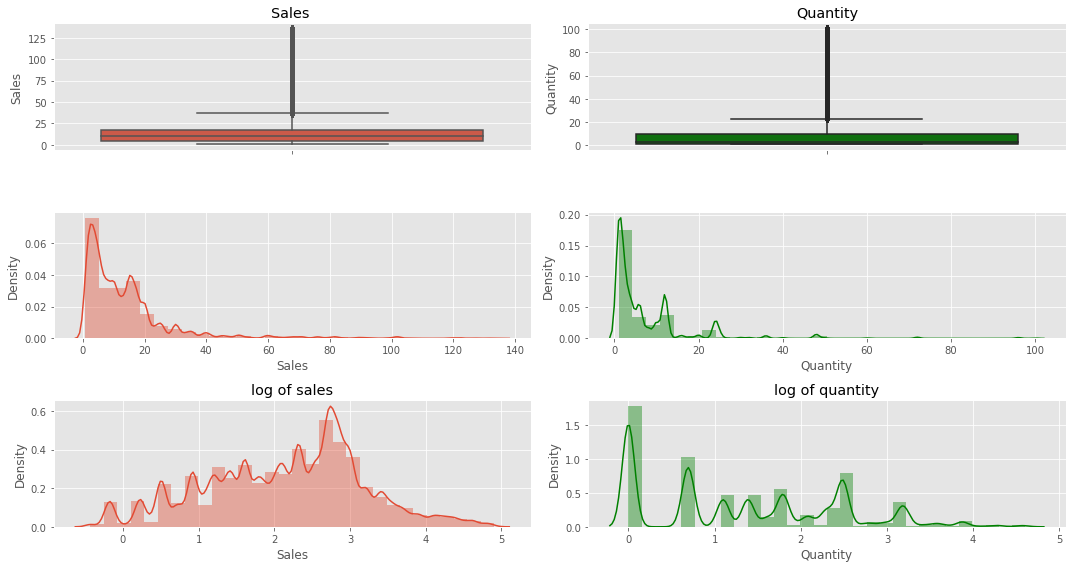

In [12]:
#plot sales and quantity after getting rid of outliers
f,ax = plt.subplots(3,2, figsize=(15,8))
sns.boxplot(y=df_new.Sales,ax=ax[0,0])
ax[0,0].set_title('Sales ')
sns.boxplot(y=df_new.Quantity,ax=ax[0,1],color='green')
ax[0,1].set_title('Quantity')

sns.distplot(df_new.Sales,ax=ax[1,0],bins=30)
sns.distplot(df_new.Quantity,ax=ax[1,1],bins=30,color='green')
#the distribution is skewed to the right with many orders between 1 and 

sns.distplot(np.log(df_new.Sales),ax=ax[2,0],bins=30)
ax[2,0].set_title('log of sales')
sns.distplot(np.log(df_new.Quantity),ax=ax[2,1],bins=30,color='green')
ax[2,1].set_title('log of quantity')
plt.tight_layout()

In [13]:
np.exp(2.8),np.exp(0)

(16.444646771097048, 1.0)

>There are a lot of sales at about 16 pounds and most quantities are small around 1

In [24]:
#how much data is lost
lost_data = df.shape[0] - df_new.shape[0]
print('data lost: {}\npercentage of lost data: {} %'.format(lost_data,lost_data/df.shape[0]*100))


data lost: 28964
percentage of lost data: 2.9043987140585172 %


[Menu](#menu)
<a id=data_exploration></a>
### Data Exploration

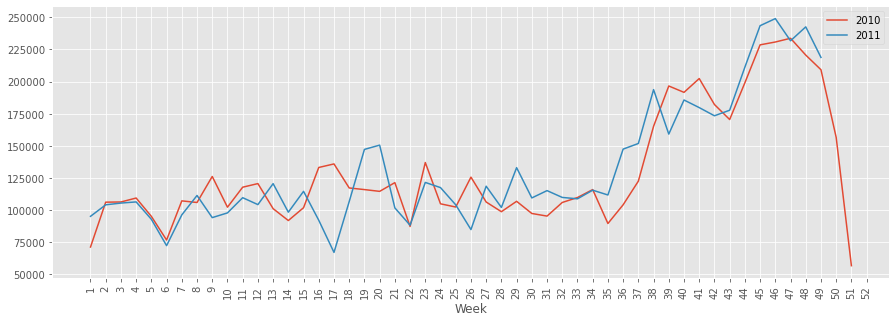

In [16]:
#yearly trends
df_new[df_new.Year==2010].groupby(['Week'])['Sales'].sum().plot(figsize=(15,5),label='2010')
df_new[df_new.Year==2011].groupby(['Week'])['Sales'].sum().plot(figsize=(15,5),label='2011')

plt.xticks(range(1,53,1),rotation=90)
plt.legend();

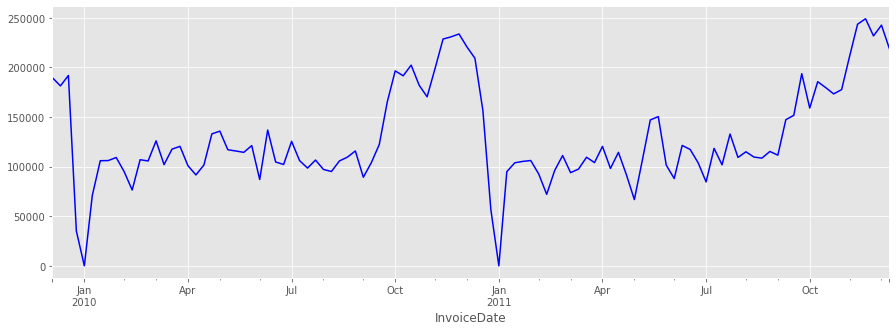

In [17]:
#look at weekly sales
df_new.set_index('InvoiceDate')['Sales'].resample('w').sum().plot(figsize=(15,5),color='blue');

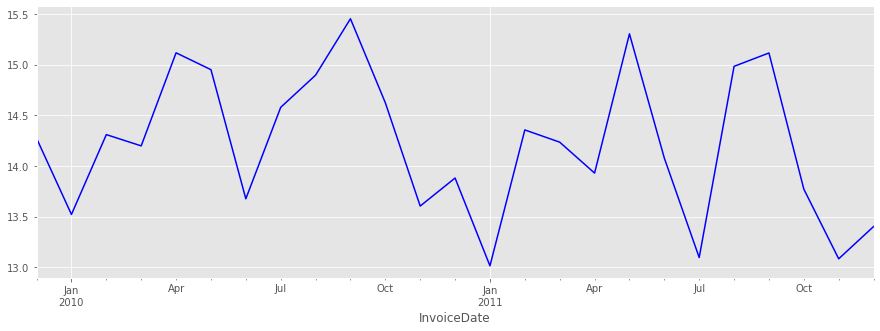

In [18]:
df_new.set_index('InvoiceDate')['Sales'].resample('m').mean().plot(figsize=(15,5),color='blue');

There is an increase in sales in November and December. This increase will affect the model and might skew the results so I think the best solution is to have two data sets to predict on, one before the Christmas period and one for the Christmas period


[Menu](#menu)
<a id=random_forest_before></a>
### LinearRegression and Shap Values

In [25]:
#create a dataframe grouped by features
group_features = ['InvoiceDate', 'Year', 'Quarter', 'Month', 'Week', 'Day','Week_day', 'Day_of_year', 'StockCode']
df_grouped = pd.DataFrame(df_new.groupby(group_features)['Quantity'].sum(),columns = ['Quantity'])
df_grouped['Sales'] = df_new.groupby(group_features)['Sales'].sum()
df_grouped= df_grouped.reset_index()


In [26]:
#change the InvoiceDate to include only date
df_grouped.InvoiceDate = df_grouped.InvoiceDate.dt.date
df_grouped.InvoiceDate = pd.to_datetime(df_grouped.InvoiceDate)
df_grouped.info()
df_grouped.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954893 entries, 0 to 954892
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceDate  954893 non-null  datetime64[ns]
 1   Year         954893 non-null  int64         
 2   Quarter      954893 non-null  int64         
 3   Month        954893 non-null  int64         
 4   Week         954893 non-null  int64         
 5   Day          954893 non-null  int64         
 6   Week_day     954893 non-null  int64         
 7   Day_of_year  954893 non-null  int64         
 8   StockCode    954893 non-null  object        
 9   Quantity     954893 non-null  int64         
 10  Sales        954893 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(8), object(1)
memory usage: 80.1+ MB


,InvoiceDate,Year,Quarter,Month,Week,Day,Week_day,Day_of_year,StockCode,Quantity,Sales
0,2009-12-01,2009,4,12,49,1,1,335,21232,24,30.0
1,2009-12-01,2009,4,12,49,1,1,335,21523,10,59.5
2,2009-12-01,2009,4,12,49,1,1,335,21871,24,30.0
3,2009-12-01,2009,4,12,49,1,1,335,22041,48,100.8
4,2009-12-01,2009,4,12,49,1,1,335,22064,24,39.6


In [27]:
X = df_grouped.drop(['InvoiceDate','StockCode','Quantity','Sales'],axis=1).values
scaler = StandardScaler()
y = np.log(df_grouped.Quantity)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [28]:
lr_model = LinearRegression().fit(X_train,y_train)
print('R2={}%'.format(lr_model.score(X_train,y_train)*100))
y_pred_lr = lr_model.predict(X_test)
print('RMSE= {}\nAME= {}'.format(np.sqrt(mean_squared_error(y_test,y_pred_lr)),mean_absolute_error(y_test,y_pred_lr)))

R2=0.18183866519220215%
RMSE= 1.1303547789971389
AME= 0.9689688251401262


In [29]:
score_dict={}
score_dict['linearRegressionOriginal'] = [round(lr_model.score(X_train,y_train)*100,2)]
score_dict['linearRegressionOriginal'].append(round(np.sqrt(mean_squared_error(y_test,y_pred_lr)),2))
score_dict['linearRegressionOriginal'].append(round(mean_absolute_error(y_test,y_pred_lr),2))


score_dict

{'linearRegressionOriginal': [0.18, 1.13, 0.97]}

In [30]:
score_df = pd.DataFrame(score_dict.values(), columns = ['score %','RMSE','MAE'], 
                        index=score_dict.keys())



In [ ]:
# Number of trees in random forest
n_estimators = [200,400,800] #[int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]#num is number of samples to generate
# Minimum number of samples required to split a node
min_samples_split = [2,5,10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

params_rf = {'n_estimators':n_estimators,
            'max_features':max_features,
            'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf}
model = RandomForestRegressor()
grid_random_forest = RandomizedSearchCV(estimator=model,param_distributions=params_rf,
                                        scoring='neg_root_mean_squared_error',
                                       n_iter=10, verbose=10,n_jobs=-1, cv=3)
model_fit = grid_random_forest.fit(X,y)

In [ ]:
model_fit.best_params_

In [31]:
model_rf = RandomForestRegressor(n_estimators= 200,
 min_samples_split= 10,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 30).fit(X_train,y_train)

In [32]:
#R2
print('R2',model_rf.score(X_train,y_train)*100)
y_pred_rf = model_rf.predict(X_test)

R2 4.317923558707171


In [33]:
score_df.loc['RandomForestOriginal'] = [model_rf.score(X_train,y_train)*100, round(np.sqrt(mean_squared_error(y_test,y_pred_rf)),2),
                                       round(mean_absolute_error(y_test,y_pred_rf),2)]

score_df

,score %,RMSE,MAE
linearRegressionOriginal,0.180000,1.13,0.97
RandomForestOriginal,4.317924,1.11,0.94


Model has a very low value of 4% which means the model does not fit the data at all 

In [ ]:
X = df_grouped.drop(['InvoiceDate','StockCode','Quantity','Sales'],axis=1)
sample = X.sample(frac=0.1).values
#run shap
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(sample)

In [ ]:
shap_df = pd.DataFrame(shap_values, columns = df_grouped.drop(['InvoiceDate','StockCode','Quantity','Sales'],axis=1).columns)

In [ ]:
shap_df

In [ ]:
shap.summary_plot(shap_values,shap_df.columns, plot_type='bar')

In [ ]:
sample_df = pd.DataFrame(shap_values,columns = df_grouped.drop(['InvoiceDate','StockCode','Quantity','Sales'],axis=1).columns)



In [ ]:
#shap values show the positive and negative relationships of the predictors with the target variable
#shap.summary_plot(shap_values,shap_df.columns)
f,ax = plt.subplots(figsize=(15,5))
shap.summary_plot(shap_values,sample_df)


[Menu](#menu)
<a id=new_features></a>
### Create New Features

In [17]:
#I would like to use stockcode in my model, 
#how many stockcodes
df_grouped.StockCode.nunique()


4883

In [23]:
#there are too many, I will use kmeans to cluster stockcode
#I will use sqrt(#of codes/2) for the number of clusters
np.sqrt(df_grouped.StockCode.nunique()/2)

49.411537114321796

In [18]:
#Since the target variables, sales and quantity are right skewed, median is a better measure of center
#get their median and mean prices, create a stockcode df called items
items = pd.DataFrame(index=df_grouped.StockCode.unique(), columns = ['medianPrice'])
items['medianPrice'] = data.groupby('StockCode')['Price'].median()
items['medianQuantity'] = data.groupby('StockCode')['Quantity'].median()
items['customersCount'] = data.groupby('StockCode')['Customer ID'].count()
items.head()

,medianPrice,medianQuantity,customersCount
21232,1.25,12.0,2459
21523,7.95,2.0,1119
21871,1.25,6.0,775
22041,2.55,4.0,557
22064,1.65,4.0,703


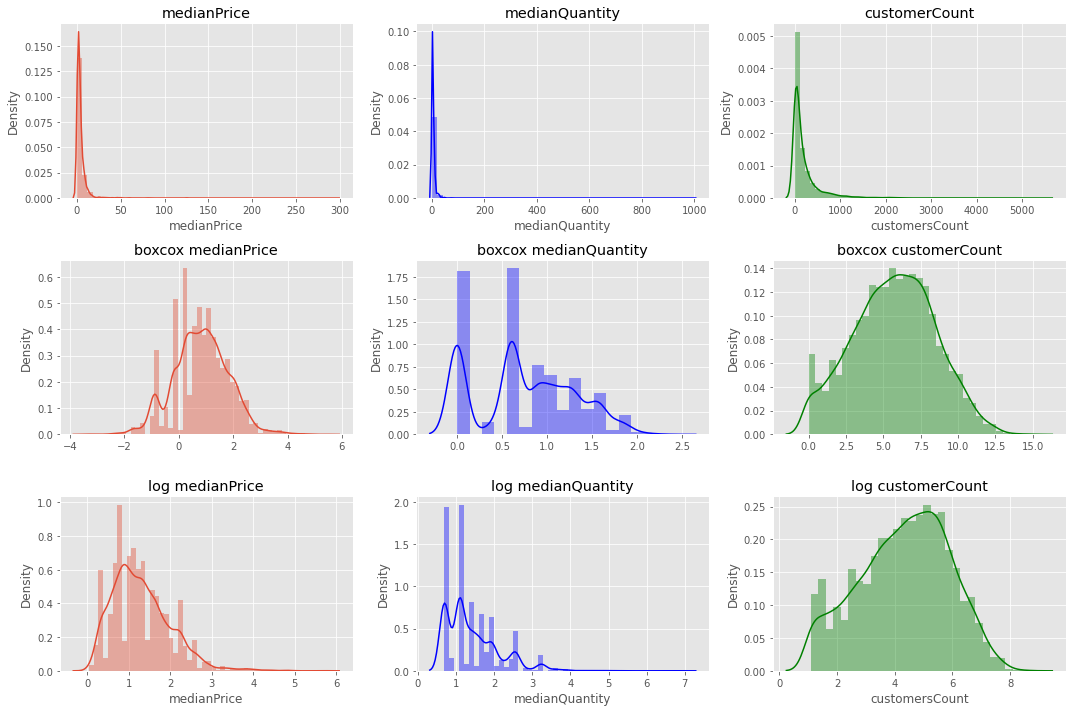

In [25]:
f,ax = plt.subplots(3,3,figsize=(15,10))

sns.distplot(items.medianPrice,ax=ax[0,0])
ax[0,0].set_title('medianPrice')
sns.distplot(items.medianQuantity,ax=ax[0,1],color='blue')
ax[0,1].set_title('medianQuantity')
sns.distplot(items.customersCount,ax=ax[0,2],color='green')
ax[0,2].set_title('customerCount')

sns.distplot(stats.boxcox(items.medianPrice)[0],ax=ax[1,0])
ax[1,0].set_title('boxcox medianPrice')
sns.distplot(stats.boxcox(items.medianQuantity)[0],ax=ax[1,1],color='blue')
ax[1,1].set_title('boxcox medianQuantity')
sns.distplot(stats.boxcox(items.customersCount)[0],ax=ax[1,2],color='green')
ax[1,2].set_title('boxcox customerCount')

sns.distplot(np.log1p(items.medianPrice),ax=ax[2,0])
ax[2,0].set_title('log medianPrice')
sns.distplot(np.log1p(items.medianQuantity),ax=ax[2,1],color='blue')
ax[2,1].set_title('log medianQuantity')
sns.distplot(np.log1p(items.customersCount+1),ax=ax[2,2],color='green')
ax[2,2].set_title('log customerCount')

plt.tight_layout();

Quantity is bimodal which means that there are two distributions. 

In [19]:
print('medianPrice log skew={}, boxcox skew={}'.format(np.log1p(items.medianPrice).skew(),\
                                                       pd.Series(stats.boxcox(items.medianPrice)[0]).skew()))
print('medianQuantity log skew={}, boxcox skew={}'.format(np.log1p(items.medianQuantity).skew(),\
                                                       pd.Series(stats.boxcox(items.medianQuantity)[0]).skew()))
print('customersCount log skew={}, boxcox skew={}'.format(np.log1p(items.customersCount).skew(),\
                                                       pd.Series(stats.boxcox(items.customersCount)[0]).skew()))


medianPrice log skew=0.9592438135912229, boxcox skew=-0.0026917979636690453
medianQuantity log skew=1.3462332479964967, boxcox skew=0.10971395731808284
customersCount log skew=-0.3148270756805804, boxcox skew=-0.03470422071794625


In [20]:
#boxcox gives a more normal distribution for all the distributions so I will use it however there are customer counts 
#at 0 since the dataframe has customers that are nans it makes sense

for col in items.columns:
    items[col] = stats.boxcox(items[col])[0]


red means higher 


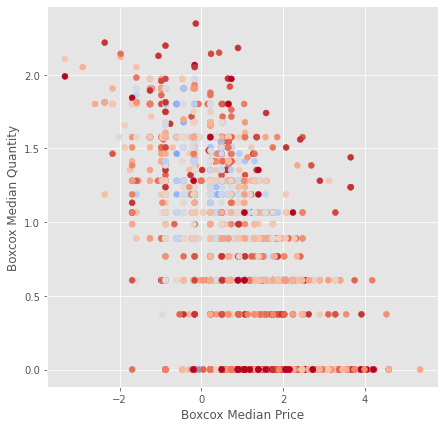

In [28]:
plt.figure(figsize=(7,7))
plt.scatter(items.medianPrice,items.medianQuantity, c = items.customersCount.values,cmap='coolwarm_r')
plt.xlabel('Boxcox Median Price')
plt.ylabel('Boxcox Median Quantity')
print('red means higher ')

In [21]:
#apply statndardscaler and kmeans with 40 clusters
X = items.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [22]:
#add the clusters to df_grouped
kmeans = KMeans(n_clusters=40)
kmeans.fit(X)
items['cluster'] = kmeans.predict(X)
df_grouped['productGroup'] = df_grouped.StockCode.map(items.cluster)
#change the cluster to object instead of int
df_grouped.productGroup = df_grouped.productGroup.astype('object')
df_grouped.head()

,InvoiceDate,Year,Quarter,Month,Week,Day,Week_day,Day_of_year,StockCode,Quantity,Sales,productGroup
0,2009-12-01,2009,4,12,49,1,1,335,21232,24,30.0,15
1,2009-12-01,2009,4,12,49,1,1,335,21523,10,59.5,26
2,2009-12-01,2009,4,12,49,1,1,335,21871,24,30.0,15
3,2009-12-01,2009,4,12,49,1,1,335,22041,48,100.8,0
4,2009-12-01,2009,4,12,49,1,1,335,22064,24,39.6,0


In [23]:
#now I will add the median quantity and sales to df_grouped
df_grouped['medianStockCodePrice'] = df_grouped.StockCode.map(data.groupby('StockCode').Price.median())

In [24]:
group = ['StockCode','Year','Month','Week','Week_day']
data_grouped = data.groupby(group)
median_price_grouped = data_grouped['Price'].median().round(2)
mean_price_grouped = data_grouped['Price'].mean().round(2)
std_price_grouped = data_grouped['Price'].std().round(2)


In [25]:
#set index of df_grouped to same as group list and map the columns of median and mean and std
df_grouped = df_grouped.set_index(group)
df_grouped['median_price_grouped'] = df_grouped.index.map(median_price_grouped)
df_grouped['mean_price_grouped'] = df_grouped.index.map(mean_price_grouped)
df_grouped['std_price_grouped'] = df_grouped.index.map(std_price_grouped)
df_grouped = df_grouped.reset_index()



In [34]:
df_grouped.head(2)

,StockCode,Year,Month,Week,Week_day,InvoiceDate,Quarter,Day,Day_of_year,Quantity,Sales,productGroup,medianStockCodePrice,median_price_grouped,mean_price_grouped,std_price_grouped
0,21232,2009,12,49,1,2009-12-01,4,1,335,24,30.0,26,1.25,1.25,1.36,0.38
1,21523,2009,12,49,1,2009-12-01,4,1,335,10,59.5,28,7.95,6.75,6.55,0.40


In [35]:
df_copy = df_grouped.copy()

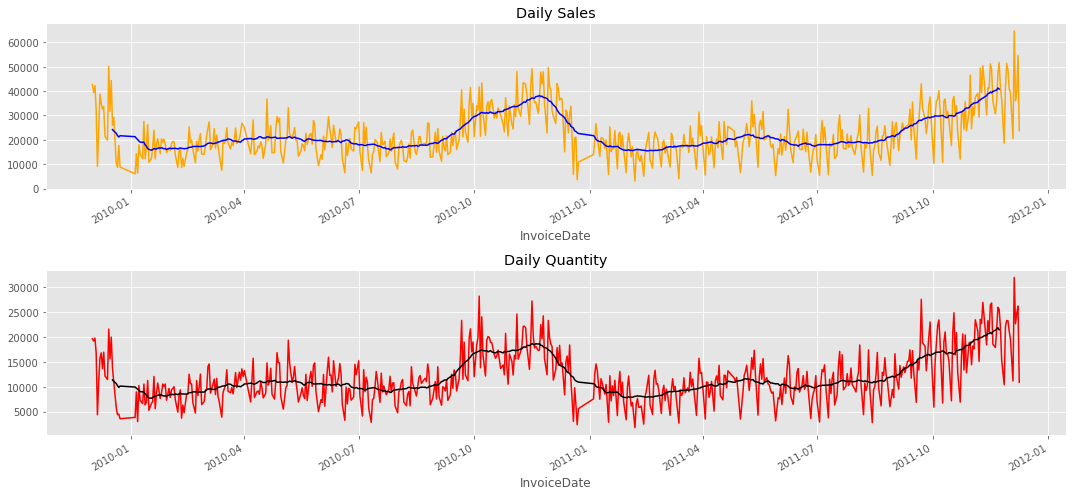

In [26]:
#daily sales
f,ax = plt.subplots(2,1,figsize=(15,7))
df_grouped.groupby('InvoiceDate').Sales.sum().plot(ax=ax[0],label='Sales',c='orange')
df_grouped.groupby('InvoiceDate').Sales.sum().rolling(window=30,center=True).mean().plot(ax=ax[0],c='blue')

ax[0].set_title('Daily Sales')
df_grouped.groupby('InvoiceDate').Quantity.sum().plot(ax=ax[1],c='red')
df_grouped.groupby('InvoiceDate').Quantity.sum().rolling(window=30,center=True).mean().plot(ax=ax[1],c='black')
ax[1].set_title('Daily Quantity')
plt.tight_layout();

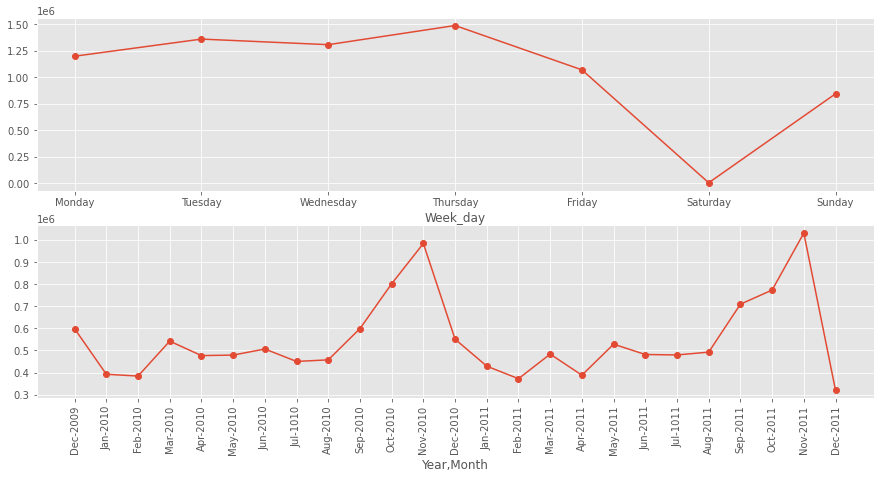

In [37]:
#plot weekly and monthly quantity sold
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
months = ["Dec-2009","Jan-2010", "Feb-2010", "Mar-2010", "Apr-2010", "May-2010",
             "Jun-2010", "Jul-1010", "Aug-2010", "Sep-2010", "Oct-2010", "Nov-2010", 
             "Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011", 
             "Dec-2011"]

f,ax = plt.subplots(2,1,figsize=(15,7))

df_grouped.groupby('Week_day').Quantity.sum().plot(ax=ax[0],marker='o')
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays)

df_grouped.groupby(['Year','Month']).Sales.sum().plot(ax=ax[1],marker='o')
ax[1].set_xticks(np.arange(0,len(months)))
ax[1].set_xticklabels(months,rotation=90);


* Highest sales on Thursday
* Christmas period starts on September and peaks on November after which it starts slowing down
* January and February have low sales
* Saturday has no transactions at all

In [27]:
#min and max for christmas period
print(df_grouped[(df_grouped.Month==12)&(df_grouped.Year==2009)]['Day_of_year'].max())
df_grouped[(df_grouped.Month==9)&(df_grouped.Year==2011)]['Day_of_year'].min()


357


244

In [28]:
df_grouped['ChristmasPeriod'] = (df_grouped.Day_of_year>=244)&(df_grouped.Day_of_year<=357)
df_grouped.head()

,StockCode,Year,Month,Week,Week_day,InvoiceDate,Quarter,Day,Day_of_year,Quantity,Sales,productGroup,medianStockCodePrice,median_price_grouped,mean_price_grouped,std_price_grouped,ChristmasPeriod
0,21232,2009,12,49,1,2009-12-01,4,1,335,24,30.0,15,1.25,1.25,1.36,0.38,True
1,21523,2009,12,49,1,2009-12-01,4,1,335,10,59.5,26,7.95,6.75,6.55,0.40,True
2,21871,2009,12,49,1,2009-12-01,4,1,335,24,30.0,15,1.25,3.43,2.56,1.19,True
3,22041,2009,12,49,1,2009-12-01,4,1,335,48,100.8,0,2.55,2.10,2.10,0.00,True
4,22064,2009,12,49,1,2009-12-01,4,1,335,24,39.6,0,1.65,1.65,2.16,0.87,True


In [29]:
df_grouped.ChristmasPeriod.value_counts()

False    508859
True     446034
Name: ChristmasPeriod, dtype: int64

In [30]:
#quantity and sales for prechristmas and post christas
df_grouped = df_grouped.set_index(['StockCode','ChristmasPeriod'])
df_grouped['PrePostChristmasMeanQuantity'] = df_grouped.groupby(['StockCode','ChristmasPeriod'])['Quantity'].mean().round(2)
df_grouped['PrePostChristmasMedianQuantity'] = df_grouped.groupby(['StockCode','ChristmasPeriod'])['Quantity'].median().round(2)
df_grouped['PrePostChristmasSTDQuantity'] = df_grouped.groupby(['StockCode','ChristmasPeriod'])['Quantity'].std().round(2)
df_grouped = df_grouped.reset_index()
df_grouped.head()



,StockCode,ChristmasPeriod,Year,Month,Week,Week_day,InvoiceDate,Quarter,Day,Day_of_year,Quantity,Sales,productGroup,medianStockCodePrice,median_price_grouped,mean_price_grouped,std_price_grouped,PrePostChristmasMeanQuantity,PrePostChristmasMedianQuantity,PrePostChristmasSTDQuantity
0,21232,True,2009,12,49,1,2009-12-01,4,1,335,24,30.0,15,1.25,1.25,1.36,0.38,13.21,12.0,15.67
1,21523,True,2009,12,49,1,2009-12-01,4,1,335,10,59.5,26,7.95,6.75,6.55,0.40,3.48,2.0,3.51
2,21871,True,2009,12,49,1,2009-12-01,4,1,335,24,30.0,15,1.25,3.43,2.56,1.19,8.10,6.0,10.27
3,22041,True,2009,12,49,1,2009-12-01,4,1,335,48,100.8,0,2.55,2.10,2.10,0.00,11.28,5.0,15.55
4,22064,True,2009,12,49,1,2009-12-01,4,1,335,24,39.6,0,1.65,1.65,2.16,0.87,8.23,3.0,11.95


In [31]:
#number of transactions and mean of sales per product group by counting the number of invoices per product
#first map the clusters to stockcode in data df
data['ProductGroup'] = data.StockCode.map(items.cluster)

df_grouped['NumofTransactionsPerProductGroup'] = df_grouped.productGroup.map(data.groupby('ProductGroup').Invoice.nunique())
#number of transactions per StockCode
df_grouped['NumofTransactionsPerStockCode'] = df_grouped.StockCode.map(data.groupby('StockCode')['Invoice'].nunique())
df_grouped.head()


,StockCode,ChristmasPeriod,Year,Month,Week,Week_day,InvoiceDate,Quarter,Day,Day_of_year,...,productGroup,medianStockCodePrice,median_price_grouped,mean_price_grouped,std_price_grouped,PrePostChristmasMeanQuantity,PrePostChristmasMedianQuantity,PrePostChristmasSTDQuantity,NumofTransactionsPerProductGroup,NumofTransactionsPerStockCode
0,21232,True,2009,12,49,1,2009-12-01,4,1,335,...,15,1.25,1.25,1.36,0.38,13.21,12.0,15.67,28370,2418
1,21523,True,2009,12,49,1,2009-12-01,4,1,335,...,26,7.95,6.75,6.55,0.40,3.48,2.0,3.51,23152,1119
2,21871,True,2009,12,49,1,2009-12-01,4,1,335,...,15,1.25,3.43,2.56,1.19,8.10,6.0,10.27,28370,769
3,22041,True,2009,12,49,1,2009-12-01,4,1,335,...,0,2.55,2.10,2.10,0.00,11.28,5.0,15.55,24116,552
4,22064,True,2009,12,49,1,2009-12-01,4,1,335,...,0,1.65,1.65,2.16,0.87,8.23,3.0,11.95,24116,690


In [32]:
#how popular each product is by customer ID count
df_grouped['productPopularity'] = df_grouped.StockCode.map(data.groupby('StockCode')['Customer ID'].count())


In [33]:
df_grouped.head()

,StockCode,ChristmasPeriod,Year,Month,Week,Week_day,InvoiceDate,Quarter,Day,Day_of_year,...,medianStockCodePrice,median_price_grouped,mean_price_grouped,std_price_grouped,PrePostChristmasMeanQuantity,PrePostChristmasMedianQuantity,PrePostChristmasSTDQuantity,NumofTransactionsPerProductGroup,NumofTransactionsPerStockCode,productPopularity
0,21232,True,2009,12,49,1,2009-12-01,4,1,335,...,1.25,1.25,1.36,0.38,13.21,12.0,15.67,28370,2418,2459
1,21523,True,2009,12,49,1,2009-12-01,4,1,335,...,7.95,6.75,6.55,0.40,3.48,2.0,3.51,23152,1119,1119
2,21871,True,2009,12,49,1,2009-12-01,4,1,335,...,1.25,3.43,2.56,1.19,8.10,6.0,10.27,28370,769,775
3,22041,True,2009,12,49,1,2009-12-01,4,1,335,...,2.55,2.10,2.10,0.00,11.28,5.0,15.55,24116,552,557
4,22064,True,2009,12,49,1,2009-12-01,4,1,335,...,1.65,1.65,2.16,0.87,8.23,3.0,11.95,24116,690,703


In [34]:
df_grouped.isna().sum()

StockCode                                0
ChristmasPeriod                          0
Year                                     0
Month                                    0
Week                                     0
Week_day                                 0
InvoiceDate                              0
Quarter                                  0
Day                                      0
Day_of_year                              0
Quantity                                 0
Sales                                    0
productGroup                             0
medianStockCodePrice                     0
median_price_grouped                     0
mean_price_grouped                       0
std_price_grouped                   299517
PrePostChristmasMeanQuantity             0
PrePostChristmasMedianQuantity           0
PrePostChristmasSTDQuantity            404
NumofTransactionsPerProductGroup         0
NumofTransactionsPerStockCode            0
productPopularity                        0
dtype: int6

In [35]:
df_copy = df_grouped.copy()

In [36]:
#I am going to remove std_price_grouped	 because it has too many nans
df_grouped.drop('std_price_grouped',axis=1, inplace=True)

In [37]:
df_grouped.isna().sum()

StockCode                             0
ChristmasPeriod                       0
Year                                  0
Month                                 0
Week                                  0
Week_day                              0
InvoiceDate                           0
Quarter                               0
Day                                   0
Day_of_year                           0
Quantity                              0
Sales                                 0
productGroup                          0
medianStockCodePrice                  0
median_price_grouped                  0
mean_price_grouped                    0
PrePostChristmasMeanQuantity          0
PrePostChristmasMedianQuantity        0
PrePostChristmasSTDQuantity         404
NumofTransactionsPerProductGroup      0
NumofTransactionsPerStockCode         0
productPopularity                     0
dtype: int64

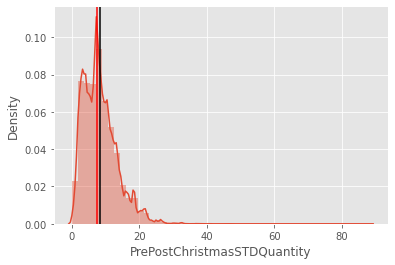

In [48]:
#there are still nans in std so I will replace them with either mean or median. To see which one is better
#plt.hist(df_grouped['PrePostChristmasSTDQuantity'])
sns.distplot(df_grouped['PrePostChristmasSTDQuantity'])
plt.axvline(df_grouped['PrePostChristmasSTDQuantity'].mean(),c='black')
plt.axvline(df_grouped['PrePostChristmasSTDQuantity'].median(),c='red')


In [38]:
#I'll use the mean to replace missing values since mean and median are very close to each other
df_grouped['PrePostChristmasSTDQuantity'].fillna(df_grouped['PrePostChristmasSTDQuantity'].mean(),inplace=True)
df_grouped.isna().sum()
df_grouped.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954893 entries, 0 to 954892
Data columns (total 22 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   StockCode                         954893 non-null  object        
 1   ChristmasPeriod                   954893 non-null  bool          
 2   Year                              954893 non-null  int64         
 3   Month                             954893 non-null  int64         
 4   Week                              954893 non-null  int64         
 5   Week_day                          954893 non-null  int64         
 6   InvoiceDate                       954893 non-null  datetime64[ns]
 7   Quarter                           954893 non-null  int64         
 8   Day                               954893 non-null  int64         
 9   Day_of_year                       954893 non-null  int64         
 10  Quantity                        

In [161]:
df_grouped.productGroup.unique()

array([15, 26,  0, 27, 24, 33, 13, 18, 28,  9, 36, 37, 16, 21,  4,  3, 11,
       34, 30,  7, 29, 10, 22, 32, 25, 39,  5, 12, 23,  8, 19,  6,  1, 14,
        2, 20, 38, 17, 31, 35])

In [39]:
#create mean, median quantity by quarter, month, and week

df_grouped = df_grouped.set_index('Quarter')
df_grouped['QuarterMeanQuantity']= df_grouped.groupby('Quarter')['Quantity'].mean().round(2)
df_grouped['QuarterMedianQuantity']= df_grouped.groupby('Quarter')['Quantity'].median().round(2)
df_grouped = df_grouped.reset_index()

df_grouped = df_grouped.set_index('Month')
df_grouped['MonthMeanQuantity']= df_grouped.groupby('Month')['Quantity'].mean().round(2)
df_grouped['MOnthMedianQuantity']= df_grouped.groupby('Month')['Quantity'].median().round(2)
df_grouped = df_grouped.reset_index()

df_grouped = df_grouped.set_index('Week_day')
df_grouped['WeekdayMeanQuantity']= df_grouped.groupby('Week_day')['Quantity'].mean().round(2)
df_grouped['WeekdayMedianQuantity']= df_grouped.groupby('Week_day')['Quantity'].median().round(2)
df_grouped = df_grouped.reset_index()


In [245]:
df_grouped.groupby(group)['Quantity'].mean().shift(1).round(2)

Week  Week_day  productGroup
1     0         0                 NaN
                2                6.35
                3               96.00
                4                9.39
                5                4.50
                                ...  
52    2         33               3.25
                34               5.50
                36              14.43
                37               2.11
                39               3.00
Name: Quantity, Length: 10918, dtype: float64

In [249]:
#add a lag feature
#weekly quantity mean and median

group = ['Week','Week_day','productGroup']
df_grouped = df_grouped.set_index(group)
df_grouped['quantityWeeklyMedianLag1'] = df_grouped.groupby(group)['Quantity'].median().shift(1).round(2)
df_grouped['quantityWeeklyMeanLag1'] = df_grouped.groupby(group)['Quantity'].mean().shift(1).round(2)
df_grouped = df_grouped.reset_index()

In [252]:
df_grouped.isna().sum()

Week                                 0
Week_day                             0
productGroup                         0
Month                                0
Quarter                              0
StockCode                            0
ChristmasPeriod                      0
Year                                 0
InvoiceDate                          0
Day                                  0
Day_of_year                          0
Quantity                             0
Sales                                0
medianStockCodePrice                 0
median_price_grouped                 0
mean_price_grouped                   0
PrePostChristmasMeanQuantity         0
PrePostChristmasMedianQuantity       0
PrePostChristmasSTDQuantity          0
NumofTransactionsPerProductGroup     0
NumofTransactionsPerStockCode        0
productPopularity                    0
QuarterMeanQuantity                  0
QuarterMedianQuantity                0
MonthMeanQuantity                    0
MOnthMedianQuantity      

In [253]:
df_grouped.dropna(inplace=True)
df_grouped.isna().sum()

Week                                0
Week_day                            0
productGroup                        0
Month                               0
Quarter                             0
StockCode                           0
ChristmasPeriod                     0
Year                                0
InvoiceDate                         0
Day                                 0
Day_of_year                         0
Quantity                            0
Sales                               0
medianStockCodePrice                0
median_price_grouped                0
mean_price_grouped                  0
PrePostChristmasMeanQuantity        0
PrePostChristmasMedianQuantity      0
PrePostChristmasSTDQuantity         0
NumofTransactionsPerProductGroup    0
NumofTransactionsPerStockCode       0
productPopularity                   0
QuarterMeanQuantity                 0
QuarterMedianQuantity               0
MonthMeanQuantity                   0
MOnthMedianQuantity                 0
WeekdayMeanQ

In [260]:
#save the new df
df_grouped.to_csv('df_new_features.csv')

[Menu](#menu)
<a Id=random_forest_new_df></a>
### Run Linear Regression, Treeregressor and Random Forest on New DataFrame

<a id =linear_regression></a>
### Linear Regression and Lasso

In [6]:
#option read in the data, used for AWS
df_grouped = pd.read_csv('df_new_features.csv',index_col=0)

In [7]:
df_grouped.shape

(954856, 30)

#### Train and Test datasets

In [8]:
#create X and y, remove year because it is least important 
X = df_grouped.drop(['InvoiceDate','Quantity','Sales','StockCode','Year'],axis=1)
y= df_grouped['Quantity']
y_log = np.log1p(df_grouped.Quantity)

#test,train
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=123)
X_train,X_test,ylog_train,ylog_test = train_test_split(X,y_log,test_size=0.25,random_state=123)

#scale training and test data separately to avoid data leakage
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)




#### Run LinearRegression

In [255]:
lr_model_2 = LinearRegression().fit(X_train,y_train)
print('R2 no log transformation= {}%',np.round(lr_model_2.score(X_train,y_train)*100,2))
lr_model_2 = LinearRegression().fit(X_train,ylog_train)
print('R2 log transformation= {}%',np.round(lr_model_2.score(X_train,ylog_train)*100,2))


R2 no log transformation= {}% 23.6
R2 log transformation= {}% 26.36


In [256]:
#log values for y gives better score
#predict
y_pred_lr = lr_model_2.predict(X_test)
#metrics
print('new RMSE= ', np.sqrt(mean_squared_error(ylog_test,y_pred_lr)))
print('new AME = ',mean_absolute_error(ylog_test,y_pred_lr))

new RMSE=  0.7775301207146667
new AME =  0.629157693214707


>The scores are for the original data set without the added features, and after adding all the features.  


In [39]:
#% accuracy of predictions for training set
pred_lr_train = lr_model_2.predict(X_train)
err_lr_train = np.mean((abs(pred_lr_train-ylog_train)/ylog_train)*100)
acc_lr_train = 100-err_lr_train

#accuracy of prediction for test set
y_pred_lr = lr_model_2.predict(X_test)
err_lr_test = np.mean((abs(y_pred_lr-ylog_test)/ylog_test)*100)
acc_lr_test = 100-err_lr_test
acc_lr_train, acc_lr_test

(49.14762373394831, 48.93364938503502)

In [40]:
score_df['%accuracy_train'] = ''
score_df['%accuracy_test'] = ''
score_df

,score %,RMSE,MAE,%accuracy_traing,%accuracy_test
linearRegressionOriginal,0.180000,1.13,0.97,,
RandomForestOriginal,4.317924,1.11,0.94,,


In [42]:
score_df

,score %,RMSE,MAE,%accuracy_traing,%accuracy_test
linearRegressionOriginal,0.180000,1.13,0.97,,
RandomForestOriginal,4.317924,1.11,0.94,,
linearRegressionAfter,NaN,NaN,NaN,49.15,48.93


>After stands for after feature creation

In [52]:
round(lr_model_2.score(X_train,ylog_train)*100,2)

26.45

In [57]:
#there is a great improvement in R2 and log transformed y give better results, so this is what i will use for the other models
#add scores to score_df that has all the scores from all the models used
score_df.at['linearRegressionAfter','score %'] = round(lr_model_2.score(X_train,ylog_train)*100,2)
score_df.at['linearRegressionAfter','RMSE'] = round(np.sqrt(mean_squared_error(ylog_test,y_pred_lr)),2)
score_df.at['linearRegressionAfter','MAE'] = round(mean_absolute_error(ylog_test,y_pred_lr),2)

score_df.at['linearRegressionAfter','%accuracy_train']= round(acc_lr_train,2)
score_df.at['linearRegressionAfter','%accuracy_test'] = round(acc_lr_test,2)

score_df


,score %,RMSE,MAE,%accuracy_traing,%accuracy_test
linearRegressionOriginal,0.180000,1.13,0.97,,
RandomForestOriginal,4.317924,1.11,0.94,,
linearRegressionAfter,26.450000,0.78,0.63,49.15,48.93


>R2 is better and RMSE is lower after feature creation

> Highest weight is given to day of year and to month

In [59]:
from sklearn.linear_model import Lasso
lasso = Lasso().fit(X_train,ylog_train)
print('lasso',lasso.score(X_train,ylog_train))

#predict with lasso
y_pred_lasso = lasso.predict(X_test)
print(np.sqrt(mean_squared_error(ylog_test,y_pred_lasso)))

score_df.at['lasso','score %'] = lasso.score(X_train,ylog_train)*100
score_df.at['lasso','RMSE'] = round(np.sqrt(mean_squared_error(ylog_test,y_pred_lasso)),2)
score_df.at['lasso','MAE'] = round(mean_absolute_error(ylog_test,y_pred_lasso),2)
 
score_df

lasso 0.0
0.9024012396258203


,score %,RMSE,MAE,%accuracy_traing,%accuracy_test
linearRegressionOriginal,0.180000,1.13,0.97,,
RandomForestOriginal,4.317924,1.11,0.94,,
linearRegressionAfter,26.450000,0.78,0.63,49.15,48.93
lasso,0.000000,0.90,0.77,NaN,NaN


>Using Lasso regression reduces the features to 0

[Menu](#menu)
<a id=important_functions></a>
### Important Functions

In [51]:
"""
function calculates mean absolute percentage error for training and test sets, which measures how close 
predictions are to actual values
parameters: 
    model, training data, test data, target training data, and target test data
returns:
    mean absolute percentage error(MAPE) for each training and test data
"""

def mape(model,X_train,X_test,y_train, y_test,return_predictions = False):
    #% accuracy of predictions for training set
    pred_train = model.predict(X_train)
    #calculate errors
    err_train = abs(pred_train-y_train)
    #mean absolute precentage error
    mape_train = (err_train/y_train)*100
    #calculate accuracy
    accuracy_train = 100 - np.mean(mape_train)
        
    #accuracy of prediction for test set
    pred_test = model.predict(X_test)
     #calculate errors
    err_test = abs(pred_test-y_test)
    #mean absolute precentage error
    mape_test = (err_test/y_test)*100
    #calculate accuracy
    accuracy_test = 100 - np.mean(mape_test)
    
    if return_predictions:
        return pred_train,pred_test,accuracy_train,accuracy_test
    else:
        return accuracy_train, accuracy_test


In [64]:
"""
function performs random search
takes:
    training data(X,y) and testing data(X_test),
    parameters to be tested 
    if I want the model to predict 
returns:
    best parameters
    the model
    predictions
"""
def randomSearch(X_train,y_train,X_test,y_test,parameters,model, predict=False):
    #estimator = model
    
    
    clf = RandomizedSearchCV(estimator=model, 
                       param_distributions =parameters,                      
                       n_iter=5,  
                       n_jobs=-1, cv=3, 
                       verbose=2,
                       random_state = 123)
    fitted_model = clf.fit(X_train,y_train)
    best_params = fitted_model.best_params_
    
    if predict:
        y_pred = fitted_model.predict(X_test)
    else:
        y_pred = None
        
    return best_params, fitted_model, y_pred

In [61]:
"""
function performs cross validation on a model
takes:
    training data (X, y)
    the model
    scoring
returns:
    best score
"""
def cross_val(X_train,y_train,model,score='neg_mean_squared_error'):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    best_score = cross_val_score(model,X_train,y_train,cv=cv,scoring=score)
    return best_score

[Menu](#menu)
<a id=decisiontree></a>
### Decision Tree Regeressor

In [62]:
#decision tree model and parameters to be tested
dt_model = DecisionTreeRegressor()
params_dt = {"criterion": ["mse"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8,10],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100]
              }

In [65]:
#call random search using decision tree model

params, best_dt_model,y_pred_dt = randomSearch(X_train,ylog_train,X_test,ylog_test,params_dt,dt_model,predict=True)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [66]:
#best_dt_model.score(X_train,ylog_train)
best_dt_model.score(X_train,ylog_train)
params

{'min_samples_split': 20,
 'min_samples_leaf': 20,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'mse'}

In [257]:
#run dt with best params
dt = DecisionTreeRegressor(min_samples_split= 20,
                         min_samples_leaf= 20,
                         max_leaf_nodes= 100,
                         max_depth= 10,
                         criterion= 'mse')
dt.fit(X_train,ylog_train)

DecisionTreeRegressor(max_depth=10, max_leaf_nodes=100, min_samples_leaf=20,
                      min_samples_split=20)

In [258]:
#accuracy of predictions
pred_train_dt,y_pred_dt,accuracy_dt_train,accuracy_dt_test = mape(dt,X_train,X_test,ylog_train,ylog_test,True)
accuracy_dt_train,accuracy_dt_test

(53.41183941052058, 53.3959847376159)

In [83]:
#run model with cross validation
dt_score = cross_val(X_train,ylog_train,dt,score='neg_mean_squared_error')
mean_score = np.mean(np.sqrt((-dt_score)))


In [88]:
round((dt.score(X_train,ylog_train)*100),2)

33.47

In [95]:

score_df.at['desisionTreeWithFeatures','score %'] = np.round((dt.score(X_train,ylog_train)*100),2)
score_df.at['desisionTreeWithFeatures','RMSE'] = np.round(np.sqrt(mean_squared_error(ylog_test,y_pred_dt)),2)
score_df.at['desisionTreeWithFeatures','MAE']  = np.round(mean_absolute_error(ylog_test,y_pred_dt),2)

#add accuracy to score_df
score_df.at['desisionTreeWithFeatures','%accuracy_train'] = round(accuracy_dt_train,2)
score_df.at['desisionTreeWithFeatures','%accuracy_test'] = round(accuracy_dt_test,2)
#rmse for dt
print('rmse= ',np.sqrt(mean_squared_error(ylog_test,y_pred_dt)))
score_df

rmse=  0.7378948611248917


,score %,RMSE,MAE,%accuracy_train,%accuracy_test
linearRegressionOriginal,0.180000,1.13,0.97,,
RandomForestOriginal,4.317924,1.11,0.94,,
linearRegressionAfter,26.450000,0.78,0.63,49.15,48.93
lasso,0.000000,0.90,0.77,NaN,NaN
desisionTreeWithFeatures,33.470000,0.74,0.59,53.47,53.27


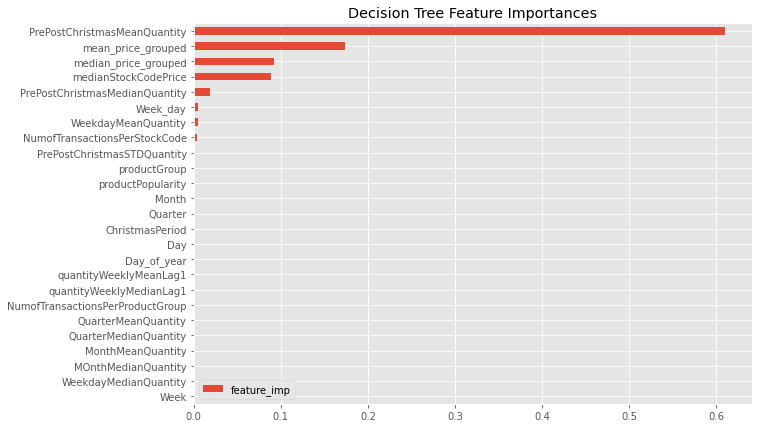

In [259]:
dt_imp = pd.DataFrame({'feature_imp':dt.feature_importances_})
dt_imp = dt_imp.set_index(X.columns)
dt_imp.sort_values(by='feature_imp').plot(kind='barh',figsize=(10,7))
plt.title('Decision Tree Feature Importances');

>most important features are prepostchristmasmeanQuantity followed by mean_price_grouped, lets see random forest


In [101]:
score_df.to_csv('scores_df.csv')

[Menu](#menu)
<a id=random_forest></a>
### Random Forest

In [97]:
rf = RandomForestRegressor(n_jobs=-1) #n_estimators here are 100, min_sample_leaf=1,max_features = auto which is sqrt
rf.fit(X_train, ylog_train)

RandomForestRegressor(n_jobs=-1)

In [98]:
#predict on test
pred_train_rf,y_pred_test,accuracy_rf_train, accuracy_rf_test = mape(rf,X_train,X_test,ylog_train,ylog_test,True)
accuracy_rf_train, accuracy_rf_test

(72.57290092893618, 52.79492019538394)

In [107]:
rmse_rf_train = np.sqrt(mean_squared_error(ylog_train,pred_train_rf))
rmse_rf_test = np.sqrt(mean_squared_error(ylog_test,y_pred_test))

score_rf = rf.score(X_train,ylog_train)
print('RMSE train= ',rmse_rf_train,'RMSE test=',rmse_rf_test, 'Score= ', score_rf)

RMSE train=  0.5035751400828262 RMSE test= 0.7985664486956419 Score=  0.6878762868860625


>The model does not perform well on predicting on the test set,also the RMSE for the training set is low(0.5), which means the model is over fitting. I need to tune the hyperparameters which might help. I will tune max_features first, then min_sample_leaf, and after I will see if changing the number trees affects accuracy significantly

In [360]:
#% of how accurate the predictions are
accuracy_rf_train, accuracy_rf_test = mape(rf,X_train,X_test,ylog_train,ylog_test)
accuracy_rf_train, accuracy_rf_test

(72.5576916600825, 52.771745002727656)

>predictions on train set has improved by almost 20% but on the test data it has decreased by a bit, it is a bit over 50% which means it is not much better than guessing

In [112]:
#add values to score_df for random forest before hyper parameter tuning
score_df.at['RandomForestNoTuning','score %'] = score_rf
score_df.at['RandomForestNoTuning','RMSE']  =  round(rmse_rf_test,2)
score_df.at['RandomForestNoTuning','MAE'] =round(mean_absolute_error(ylog_test,y_pred_test),2)
score_df.at['RandomForestNoTuning','%accuracy_train'] = round(accuracy_rf_train,2)
score_df.at['RandomForestNoTuning','%accuracy_test'] = round(accuracy_rf_test,2)
score_df

,score %,RMSE,MAE,%accuracy_train,%accuracy_test
linearRegressionOriginal,0.180000,1.13,0.97,,
RandomForestOriginal,4.317924,1.11,0.94,,
linearRegressionAfter,26.450000,0.78,0.63,49.15,48.93
lasso,0.000000,0.90,0.77,NaN,NaN
desisionTreeWithFeatures,33.470000,0.74,0.59,53.47,53.27
RandomForestNoTuning,0.687876,0.80,0.60,72.57,52.79


In [117]:
#tune max_features
params = {'max_features' : [int(x) for x in np.linspace(start=2, stop=24,num=10)],}
rf_model_f = RandomForestRegressor(n_jobs=-1)
gs_rf_f = GridSearchCV(rf_model_f,param_grid = params, scoring = 'neg_mean_squared_error',cv=3,verbose=2)
gs_rf_f.fit(X_train,ylog_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....................................max_features=2; total time=  21.3s
[CV] END .....................................max_features=2; total time=  18.7s
[CV] END .....................................max_features=2; total time=  18.4s
[CV] END .....................................max_features=4; total time=  25.8s
[CV] END .....................................max_features=4; total time=  26.6s
[CV] END .....................................max_features=4; total time=  24.1s
[CV] END .....................................max_features=6; total time=  33.2s
[CV] END .....................................max_features=6; total time=  34.9s
[CV] END .....................................max_features=6; total time=  34.4s
[CV] END .....................................max_features=9; total time=  42.1s
[CV] END .....................................max_features=9; total time=  45.1s
[CV] END .....................................ma

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_features': [2, 4, 6, 9, 11, 14, 16, 19, 21, 24]},
             scoring='neg_mean_squared_error', verbose=2)

In [137]:
np.sqrt(-gs_rf_f.cv_results_['mean_test_score'][0])

0.7947791028480411

In [124]:
pred_train,y_pred, accuracy_train,accuracy_test = mape(rf,X_train,X_test,ylog_train,ylog_test,True)

In [295]:
features = [int(x) for x in np.linspace(start=2, stop=24,num=10)]
acc_train = []
acc_test = []
RMSE = []


for feature in features:
    rf = RandomForestRegressor(max_features=feature)
    rf.fit(X_train,ylog_train)
    print('trained')
    pred_train,y_pred, accuracy_train,accuracy_test = mape(rf,X_train,X_test,ylog_train,ylog_test,True)
    
    acc_train.append(accuracy_train)
    acc_test.append(accuracy_test)
    RMSE.append(np.sqrt(mean_squared_error(ylog_test,y_pred)))
    print('done')

trained
done
trained
done
trained
done
trained
done
trained
done
trained
done
trained
done
trained
done
trained
done
trained
done


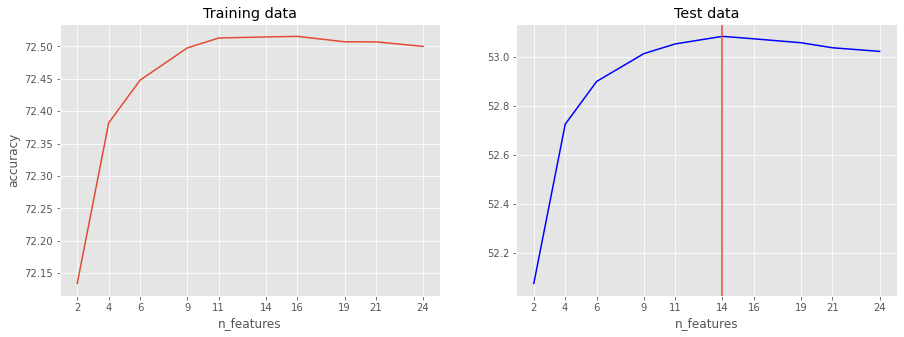

In [302]:
f,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(features,acc_train)
ax[0].set_title('Training data')
ax[0].set_xticks(features)
ax[0].set_xlabel('n_features')
ax[0].set_ylabel('accuracy')
ax[1].plot(features,acc_test,c = 'blue')
ax[1].axvline(x=14)
ax[1].set_title('Test data')
ax[1].set_xticks(features)
ax[1].set_xlabel('n_features');

For both the test and training sets it seems that at 13 score starts to stabilize, like in the case of the test set, or it dips down. Also after 6 features the accuracy score stays increasing but it slows down

In [185]:
#now tune max_sample_leaf
params = {'min_samples_leaf' : np.linspace(start=0.01,stop=0.5,num=5),
         'max_features':[16]}
rf_model_f = RandomForestRegressor(n_jobs=-1)
gs_rf_l = GridSearchCV(rf_model_f,param_grid = params, scoring = 'neg_mean_squared_error',cv=3,verbose=2)
gs_rf_l.fit(X_train,ylog_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .............max_features=16, min_samples_leaf=0.01; total time=  33.7s
[CV] END .............max_features=16, min_samples_leaf=0.01; total time=  31.6s
[CV] END .............max_features=16, min_samples_leaf=0.01; total time=  31.9s
[CV] END ...........max_features=16, min_samples_leaf=0.1325; total time=  10.4s
[CV] END ...........max_features=16, min_samples_leaf=0.1325; total time=  10.3s
[CV] END ...........max_features=16, min_samples_leaf=0.1325; total time=  10.1s
[CV] END ............max_features=16, min_samples_leaf=0.255; total time=   6.2s
[CV] END ............max_features=16, min_samples_leaf=0.255; total time=   6.1s
[CV] END ............max_features=16, min_samples_leaf=0.255; total time=   6.2s
[CV] END ...........max_features=16, min_samples_leaf=0.3775; total time=   0.8s
[CV] END ...........max_features=16, min_samples_leaf=0.3775; total time=   0.8s
[CV] END ...........max_features=16, min_samples_

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_features': [16],
                         'min_samples_leaf': array([0.01  , 0.1325, 0.255 , 0.3775, 0.5   ])},
             scoring='neg_mean_squared_error', verbose=2)

In [186]:
gs_rf_l.best_params_

{'max_features': 16, 'min_samples_leaf': 0.01}

In [219]:
#min_sample_leaf
min_samples = np.linspace(start=0.01,stop=0.5,num=5)
acc_train_s = []
acc_test_s = []
RMSE_s = []


for n_samples in min_samples:
    rf_2 = RandomForestRegressor(max_features=6,min_samples_leaf=n_samples)
    rf_2.fit(X_train,ylog_train)
    print('trained')
    pred_train_2,y_pred_2, accuracy_train_2,accuracy_test_2 = mape(rf_2,X_train,X_test,ylog_train,ylog_test,True)
    
    acc_train_s.append(accuracy_train_2)
    acc_test_s.append(accuracy_test_2)
    RMSE_s.append(np.sqrt(mean_squared_error(ylog_test,y_pred_2)))
    print('done')

trained
done
trained
done
trained
done
trained
done
trained
done


In [221]:
 acc_train_s

[51.14500522684584,
 45.885257257772224,
 43.9414990598908,
 38.05113638889815,
 38.05595878994556]

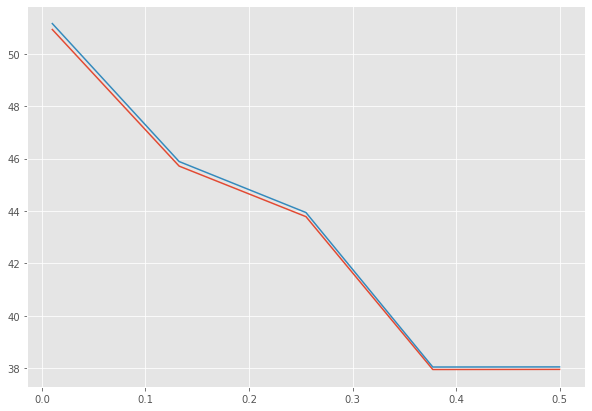

In [222]:
plt.figure(figsize=(10,7))
plt.plot(min_samples,acc_test_s)
plt.plot(min_samples,acc_train_s)

Increasing min_sample_leaf can cause underfitting

In [201]:
rf_3 = RandomForestRegressor(max_features=16,n_estimators=50, min_samples_leaf=0.1)
rf_3.fit(X_train,ylog_train)

RandomForestRegressor(max_features=16, min_samples_leaf=0.1, n_estimators=50)

In [204]:
#acc_train,acc_test = mape(rf_3,X_train,X_test,ylog_train,ylog_test)
acc_train,acc_test

(47.39862233136274, 47.20061189780654)

In [223]:
#n_estimators
n_estimators = [int(x) for x in np.linspace(start=50,stop=300,num=5)]
acc_train_e = []
acc_test_e = []
RMSE_e = []


for tree in n_estimators:
    rf_4 = RandomForestRegressor(max_features=6,n_estimators=tree, min_samples_leaf=2)
    rf_4.fit(X_train,ylog_train)
    print('trained')
    pred_train_4,y_pred_4, accuracy_train_4,accuracy_test_4 = mape(rf_4,X_train,X_test,ylog_train,ylog_test,True)
    
    acc_train_e.append(accuracy_train_4)
    acc_test_e.append(accuracy_test_4)
    RMSE_e.append(np.sqrt(mean_squared_error(ylog_test,y_pred_2)))
    print('done')

trained
done
trained
done
trained
done
trained
done
trained
done


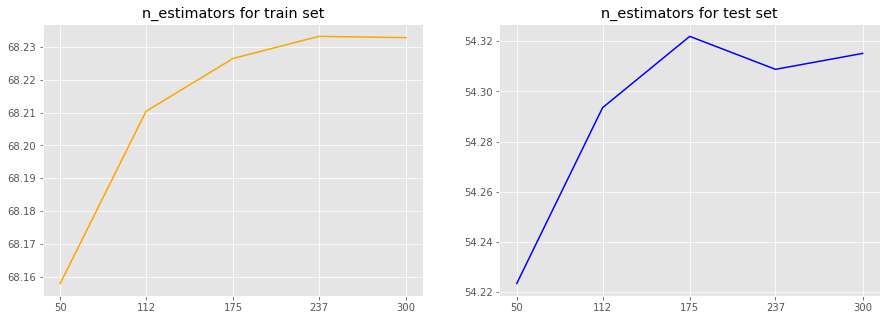

In [270]:
f,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(n_estimators,acc_train_e,c='orange')
ax[0].set_xticks(n_estimators)
ax[1].plot(n_estimators,acc_test_e,c='blue')
ax[1].set_xticks(n_estimators)
ax[0].set_title('n_estimators for train set')
ax[1].set_title('n_estimators for test set');

The model performs best at 175 trees on the test set.

In [53]:
rf_5 = RandomForestRegressor(n_estimators=175,max_features=13)
rf_5.fit(X_train,ylog_train)

RandomForestRegressor(max_features=13, n_estimators=175)

In [54]:
pred_train, y_pred,acc_tr, acc_ts = mape(rf_5,X_train, X_test, ylog_train, ylog_test,True)

In [55]:
acc_tr,acc_ts

(72.52484611411495, 53.09899329565367)

<AxesSubplot:>

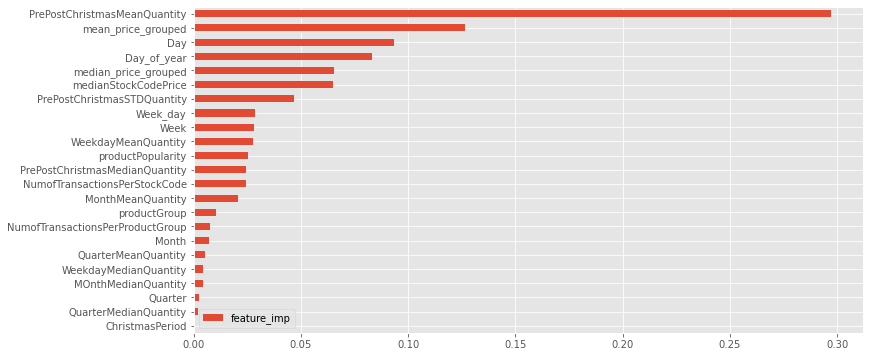

In [366]:
features = pd.DataFrame({'feature_imp':rf.feature_importances_})
features =features.set_index( X.columns)
features.sort_values(by='feature_imp').plot(kind='barh',figsize=(12,6))
#features.sort_values(by='feature_imp',ascending=False)

The most important feature is prePostChristmasMeanQuantity followed by mean_price_grouped

Now I need to tune the hyperparameters to try to improve predictions and accuracy

Most important hyperparameters of Random Forest:

• n_estimators = n of trees  
• max_features = max number of features considered for splitting a node  
• max_depth = max number of levels in each decision tree  
• min_samples_split = min number of data points placed in a node before the node is split  
• min_samples_leaf = min number of data points allowed in a leaf node  
• bootstrap = method for sampling data points (with or without replacement)  

The most important features to tune are n_estimators, followed by max_features, followed by min_sample_leaf, which when tuned can prevent over fitting. However min_sample_leaf showed that if increased it will overfit, so I will leave it with the default value of 1.

Next I will perform a random search to see if I can improve the results

In [278]:
[int(x) for x in np.linspace(1, 45, num = 3)]


[1, 23, 45]

In [283]:
#number of trees
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(start=2, stop=15,num=5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42,
                           n_jobs = -1, scoring='neg_mean_squared_error')
# Fit the random search model
rf_random.fit(X_train, ylog_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [1, 23, 45],
                                        'max_features': [2, 5, 8, 11, 15],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [50, 87, 125, 162,
                                                         200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [284]:
rf_random.best_params_

{'n_estimators': 162,
 'min_samples_split': 10,
 'max_features': 8,
 'max_depth': 23}

In [286]:
#print root mean squared error for all parameters
for params, rmse in zip(rf_random.cv_results_['params'], rf_random.cv_results_['mean_test_score']):
    print(params, 'RMSE:',np.sqrt(-rmse))

{'n_estimators': 162, 'min_samples_split': 5, 'max_features': 8, 'max_depth': 23} RMSE: 0.7365372595044616
{'n_estimators': 162, 'min_samples_split': 10, 'max_features': 5, 'max_depth': 1} RMSE: 0.8279830922457299
{'n_estimators': 162, 'min_samples_split': 10, 'max_features': 5, 'max_depth': 45} RMSE: 0.7361567371131468
{'n_estimators': 162, 'min_samples_split': 10, 'max_features': 8, 'max_depth': 23} RMSE: 0.7244777328348221
{'n_estimators': 87, 'min_samples_split': 10, 'max_features': 8, 'max_depth': 23} RMSE: 0.725111753658181


In [313]:
#use the function mape that I created to measure prediction accuracy
pred_train,y_pred,acc_train,acc_test = mape(rf_random.best_estimator_,X_train,X_test,ylog_train,ylog_test,True)

In [315]:
acc_test

55.51172110240739

In [316]:
#add values to score_df for random forest after hyper parameter tuning
#score_df.at['RandomForestAfterTuning','score %'] = score_rf
score_df.at['RandomForestAfterTuning','RMSE']  =  round(np.sqrt(mean_squared_error(ylog_test,y_pred)),2)
score_df.at['RandomForestAfterTuning','MAE'] =round(mean_absolute_error(ylog_test,y_pred),2)
score_df.at['RandomForestAfterTuning','%accuracy_train'] = round(acc_train,2)
score_df.at['RandomForestAfterTuning','%accuracy_test'] = round(acc_test,2)
score_df

,score %,RMSE,MAE,%accuracy_train,%accuracy_test
linearRegressionOriginal,0.180000,1.13,0.97,,
RandomForestOriginal,4.317924,1.11,0.94,,
linearRegressionAfter,26.450000,0.78,0.63,49.15,48.93
lasso,0.000000,0.90,0.77,NaN,NaN
desisionTreeWithFeatures,33.470000,0.74,0.59,53.47,53.27
RandomForestNoTuning,0.687876,0.80,0.60,72.57,52.79
RandomForestAfterTuning,NaN,0.73,0.56,63.81,55.51


<AxesSubplot:>

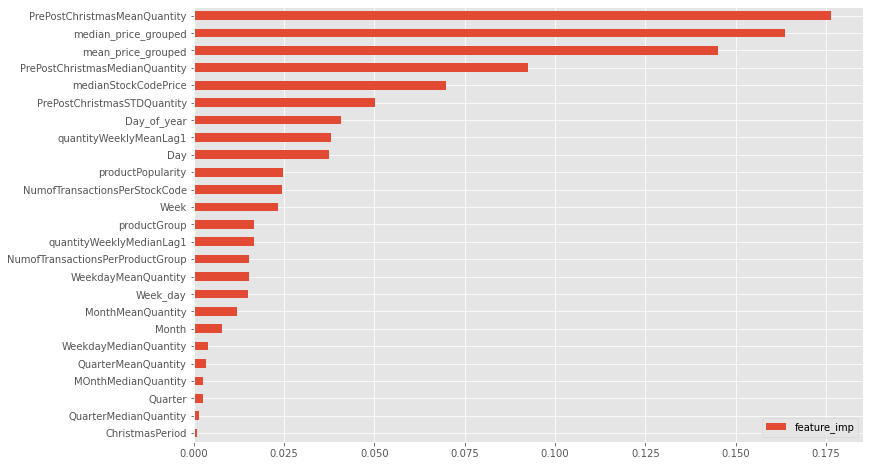

In [292]:
features = pd.DataFrame({'feature_imp':rf_random.best_estimator_.feature_importances_})
features =features.set_index( X.columns)
features.sort_values(by='feature_imp').plot(kind='barh',figsize=(12,8))
#features.sort_values(by='feature_imp',ascending=False)

>accuracy on test data improved by about 1% so I will explore more estimators but keep all other hyperparamters the same to see if I get a better fit

The most important feature is prePostChristmasMeanQuantity and the least is ChristmasPeriod and QuarterMedianQuantity. I will delete these two are fit the random forest again to see if score is improved

> The score improved slightly

In [32]:
#run pca
X_trans = scaler.fit_transform(X)
pca = PCA(10)
X_reduced = pca.fit_transform(X_trans)
#Variance (% cumulative) explained by the principal components
#plt.figure(figsize=(10,7))
#plt.plot(range(0,len(X.columns)),np.cumsum(pca.explained_variance_ratio_)*100)
X_tn_trf,X_ts_trf,y_tn_trf,y_ts_trf = train_test_split(X_reduced,y_log,test_size=0.25)

In [41]:
fited_rf_pca

RandomForestRegressor(max_depth=23, max_features=8, min_samples_split=10,
                      n_estimators=162)

In [40]:
rf_pca = RandomForestRegressor(n_estimators= 162,
                             min_samples_split = 10,
                             max_features = 8,
                             max_depth = 23)
fited_rf_pca = rf_pca.fit(X_tn_trf,y_tn_trf)

In [50]:
#pred_train_pca,y_pred_pca,acc_train_pca,acc_test_pca = mape(fited_rf_pca,X_tn_trf,X_ts_trf,y_tn_trf,y_ts_trf,True)

#np.sqrt(mean_squared_error(y_ts_trf,y_pred_pca)),mean_absolute_error(y_ts_trf,y_pred_pca)
fited_rf_pca.score(X_tn_trf,y_tn_trf),fited_rf_pca.score(X_ts_trf,y_ts_trf)


(0.5543041357781477, 0.26095804195733185)

[Menu](#menu)
<a id=xgboost></a>
### XGBoost

In [65]:
df_grouped.columns

Index(['Week', 'Week_day', 'productGroup', 'Month', 'Quarter', 'StockCode',
       'ChristmasPeriod', 'Year', 'InvoiceDate', 'Day', 'Day_of_year',
       'Quantity', 'Sales', 'medianStockCodePrice', 'median_price_grouped',
       'mean_price_grouped', 'PrePostChristmasMeanQuantity',
       'PrePostChristmasMedianQuantity', 'PrePostChristmasSTDQuantity',
       'NumofTransactionsPerProductGroup', 'NumofTransactionsPerStockCode',
       'productPopularity', 'QuarterMeanQuantity', 'QuarterMedianQuantity',
       'MonthMeanQuantity', 'MOnthMedianQuantity', 'WeekdayMeanQuantity',
       'WeekdayMedianQuantity', 'quantityWeeklyMedianLag1',
       'quantityWeeklyMeanLag1'],
      dtype='object')

In [60]:
#Run XGBoost with defaults
model_xg = XGBRegressor()
model_xg.fit(X_train,ylog_train)
#y_pred_xg = model_xg.predict(X_test)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [63]:

pred_train_xg, y_pred_xg, acc_train_xg,acc_test_xg = mape(model_xg,X_train,X_test, ylog_train,ylog_test,True)


In [18]:
acc_train_xg,acc_test_xg

(56.96179801982985, 56.518535892768234)

In [20]:
np.sqrt(mean_squared_error(ylog_test,y_pred_xg)),mean_absolute_error(ylog_test,y_pred_xg)

(0.7002533325777602, 0.5504854947897833)

### Explanation of relevant parameters for this kernel.

<b>booster</b>:  Select the type of model to run at each iteration
* gbtree: tree-based models
* gblinear: linear models. Tree booster always out performs this so gbtree will be used  

<b>nthread</b>: default to maximum number of threads available if not set
* objective: This defines the loss function to be minimized 

<b>Parameters for controlling speed</b>

* subsample: Denotes the fraction of observations to be randomly samples for each tree
* colsample_bytree: Subsample ratio of columns when constructing each tree.
* n_estimators: Number of trees to fit.

<b>Important parameters which control overfiting</b>

* learning_rate: Makes the model more robust by shrinking the weights on each step
* max_depth: The maximum depth of a tree.
* min_child_weight: Defines the minimum sum of weights of all observations required in a child.

In [23]:
model_xg = XGBRegressor()
params = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }
    
xgbSearch = GridSearchCV(estimator=model_xg,param_grid=params,n_jobs=-1,verbose=1,cv=3)
xgbSearch.fit(X_train,ylog_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


KeyboardInterrupt: 

In [117]:
#repeated k-fold cross-validation provides a way to improve the estimated performance of a machine learning model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
randomSearch
score_xg = cross_val_score(model_xg,X_train,ylog_train,cv = cv,scoring='neg_mean_absolute_error',n_jobs=-1)

KeyboardInterrupt: 

In [ ]:
score_xg_ac = cross_val_score(model_xg,X_train,ylog_train,cv = cv,scoring='r2',n_jobs=-1)

In [ ]:
score_xg_ac.mean()*100

In [ ]:
model_xg.fit(X_train,ylog_train)

In [ ]:
model_xg.score_

In [ ]:
def randomSearch(X_train,y_train,X_test,y_test,parm_grid,model,score, predict=False, cross_val = False):
    estimator = model
    param_distributions = param_grid
    
    clf = RandomizedSearchCV(estimator=model, 
                       param_distributions =param_grid,                      
                       n_iter=10, 
                       scoring=score, 
                       n_jobs=-1, cv=3, 
                       verbose=10,
                       random_state = 123)
    fitted_model = clf.fit(X_train,y_train)
    best_params = results.best_params_
    
    if predict:
        y_pred = fitted_model.predict(X_test)
        
    return best_params, fitted_model, y_pred

def cross_val(X_train,y_train,model,score='neg_mean_absolute_error'):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    best_score = model.cross_val_score(X_train,y_train,cv=cv,scoring=score)
    return best_score

In [ ]:
#models to run: linear regression, random forest, svm, xgboost
    